# Game of Thrones End-To-End Notebook

This notebook contains an end-to-end workflow using multiple csv files of Game of Thrones battle data.

In [1]:
import os
from neo4j_runway.utils.data import load_data_dictionary_from_yaml, load_local_files
from neo4j_runway.llm.openai import OpenAIDataModelingLLM, OpenAIDiscoveryLLM
from neo4j_runway.discovery import Discovery
from neo4j_runway import GraphDataModeler
from neo4j_runway.code_generation import PyIngestConfigGenerator
from neo4j_runway.ingestion import PyIngest

## Read Data

In [2]:
data_dictionary = load_data_dictionary_from_yaml("data_dictionary.yaml")
data_dictionary

{'got_armies.csv': {'battle_number': 'A unique ID for the battle.',
  'king': 'A king participating in the battle.',
  'outcome': 'Whether the battle was won or lost.',
  'family': 'A significant family in the battle.',
  'size': 'The size of the army.',
  'commander': 'The commander leading an army in the battle.',
  'attacking': 'Whether the army is attacking or not.'},
 'got_battles.csv': {'name': 'The name of the battle.',
  'year': 'The year the battle took place.',
  'battle_number': 'A unique ID for the battle.',
  'summer': 'Whether the battle took place during Summer.',
  'location': 'The location of the battle.',
  'region': 'The larger region a battle took place in.'}}

In [3]:
data_directory = "../../../data/got/multi/"
data = load_local_files(data_directory=data_directory, 
                        general_description="This file contains data on game of thrones battles", 
                        data_dictionary=data_dictionary, 
                        use_cases=["What families have changed alliances?", 
                                   "how have army sizes changed over time?", 
                                   "Which families attack most often?"],
                        )

In [4]:
data.tables[0].dataframe.head()

,battle_number,king,outcome,family,size,commander,attacking
0,1,Joffrey/Tommen Baratheon,True,Lannister,15000.0,Jaime Lannister,True
1,2,Joffrey/Tommen Baratheon,True,Lannister,NaN,Gregor Clegane,True
2,3,Joffrey/Tommen Baratheon,True,Lannister,15000.0,Jaime Lannister,True
3,3,Joffrey/Tommen Baratheon,True,Lannister,15000.0,Andros Brax,True
4,4,Robb Stark,False,Stark,18000.0,Roose Bolton,True


In [5]:
data.tables[1].dataframe.head()

,location,region,battle_number,name,summer,year
0,Golden Tooth,The Westerlands,1,Battle of the Golden Tooth,True,298
1,Mummer's Ford,The Riverlands,2,Battle at the Mummer's Ford,True,298
2,Riverrun,The Riverlands,3,Battle of Riverrun,True,298
3,Green Fork,The Riverlands,4,Battle of the Green Fork,True,298
4,Whispering Wood,The Riverlands,5,Battle of the Whispering Wood,True,298


## Discovery

In [6]:
disc_llm = OpenAIDiscoveryLLM(model_name="gpt-4o-mini", enable_async=True)
disc = Discovery(llm=disc_llm, data=data)

/Users/alexandergilmore/Documents/projects/neo4j-runway/neo4j_runway/discovery/discovery.py:133: ExperimentalFeatureWarning: Multi file Discovery is an experimental feature and may not work as expected. Please use with caution and raise any issues encountered here: https://github.com/a-s-g93/neo4j-runway/issues
  warnings.warn(


In [7]:
disc.run_async()

### Summary of Insights for Graph Data Model

#### Unique Identifiers
1. **battle_number**: Serves as a unique identifier for each battle, allowing for tracking and referencing.
2. **family**: Identifies the family associated with each army, crucial for analyzing alliances and rivalries.
3. **king**: Identifies the king associated with each army, important for understanding alliances.
4. **commander**: Identifies the commanders leading the armies, which can help in understanding leadership dynamics.

#### Significant Properties
1. **year**: The year in which the battle occurred, useful for analyzing trends over time.
2. **location**: The specific location of the battle, providing context for geographical patterns.
3. **region**: The broader region where the battle took place, helping to analyze regional conflicts.
4. **size**: The size of the army, key for analyzing trends in army strength over time.
5. **outcome**: Indicates whether the battle was won or lost, essential for assessing effectiveness.
6. **attacking**: Indicates whether the army was attacking, crucial for understanding battle dynamics.

#### Possible Node Labels
1. **Battle**: Represents each battle, with properties like battle_number, year, location, region, name, and summer.
2. **Family**: Represents each family involved in the battles, with properties like family name.
3. **King**: Represents each king associated with the armies, with properties like king name.
4. **Commander**: Represents each commander leading the armies, with properties like commander name.

#### Possible Relationships
1. **PARTICIPATED_IN**: Between Family and Battle, indicating which families participated in which battles.
2. **LED_BY**: Between Battle and Commander, indicating which commander led the battle.
3. **AFFILIATED_WITH**: Between Family and King, indicating which families are allied with which kings.
4. **HAS_ARMY**: Between Family and Army, indicating the size of the army associated with each family.

#### Addressing Use Cases
- **What families have changed alliances?**: By analyzing the **AFFILIATED_WITH** relationship over time, we can track shifts in family alliances based on their association with different kings.
- **How have army sizes changed over time?**: The **HAS_ARMY** relationship can be used to correlate army sizes with **year** to visualize trends in army strength across battles.
- **Which families attack most often?**: The **PARTICIPATED_IN** relationship can be analyzed to determine the frequency of battles involving each family, particularly focusing on the **attacking** property to identify aggressiveness.

In [8]:
disc.to_markdown(file_dir="./outputs/")

## Data Modeling

In [9]:
gdm_llm = OpenAIDataModelingLLM(model_name="gpt-4o", model_params={"temperature": 0.6})
gdm = GraphDataModeler(llm=gdm_llm, discovery=disc)

### Initial Model

In [10]:
gdm.create_initial_model(max_retries=3)

Entity Pool Generation Attempt: 1
nodes : ['Battle', 'Family', 'King', 'Commander']
rels  : ['PARTICIPATED_IN', 'LED_BY', 'AFFILIATED_WITH']
Received Valid Entity Pool.
validation failed
Number of Errors:  7 

Analyzing errors...
validation failed
Number of Errors:  3 

Analyzing errors...
validation failed
Number of Errors:  1 

Analyzing errors...


DataModel(nodes=[Node(label='Battle', properties=[Property(name='battleNumber', type='int', column_mapping='battle_number', alias='battle_number', is_unique=True, part_of_key=False), Property(name='year', type='int', column_mapping='year', alias=None, is_unique=False, part_of_key=False), Property(name='name', type='str', column_mapping='name', alias=None, is_unique=False, part_of_key=False), Property(name='summer', type='bool', column_mapping='summer', alias=None, is_unique=False, part_of_key=False), Property(name='location', type='str', column_mapping='location', alias=None, is_unique=False, part_of_key=False), Property(name='region', type='str', column_mapping='region', alias=None, is_unique=False, part_of_key=False)], source_name='got_battles.csv'), Node(label='Family', properties=[Property(name='family', type='str', column_mapping='family', alias=None, is_unique=True, part_of_key=False)], source_name='got_armies.csv'), Node(label='King', properties=[Property(name='king', type='str'

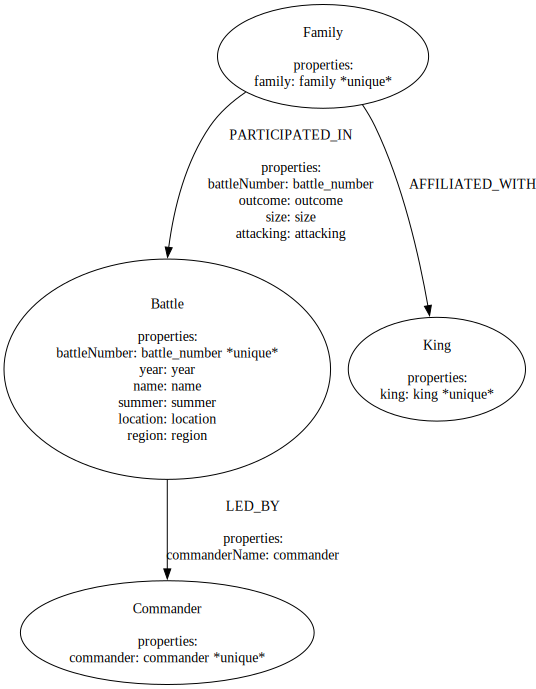

In [11]:
gdm.current_model.visualize()

### Making Corrections

In [12]:
corrections = """
1. Create separate nodes for location and region. 
2. Remove the commanderName property from the LED_BY relationship. 
3. Give LED_BY and PARTICIPATED_IN relationships the attacking and outcome properties."""
gdm.iterate_model(corrections=corrections, max_retries=3, allow_duplicate_properties=True)

validation failed
Number of Errors:  2 

Analyzing errors...
recieved a valid response


DataModel(nodes=[Node(label='Battle', properties=[Property(name='battleNumber', type='int', column_mapping='battle_number', alias='battle_number', is_unique=True, part_of_key=False), Property(name='year', type='int', column_mapping='year', alias=None, is_unique=False, part_of_key=False), Property(name='name', type='str', column_mapping='name', alias=None, is_unique=False, part_of_key=False), Property(name='summer', type='bool', column_mapping='summer', alias=None, is_unique=False, part_of_key=False)], source_name='got_battles.csv'), Node(label='Family', properties=[Property(name='family', type='str', column_mapping='family', alias=None, is_unique=True, part_of_key=False)], source_name='got_armies.csv'), Node(label='King', properties=[Property(name='king', type='str', column_mapping='king', alias=None, is_unique=True, part_of_key=False)], source_name='got_armies.csv'), Node(label='Commander', properties=[Property(name='commander', type='str', column_mapping='commander', alias=None, is_u

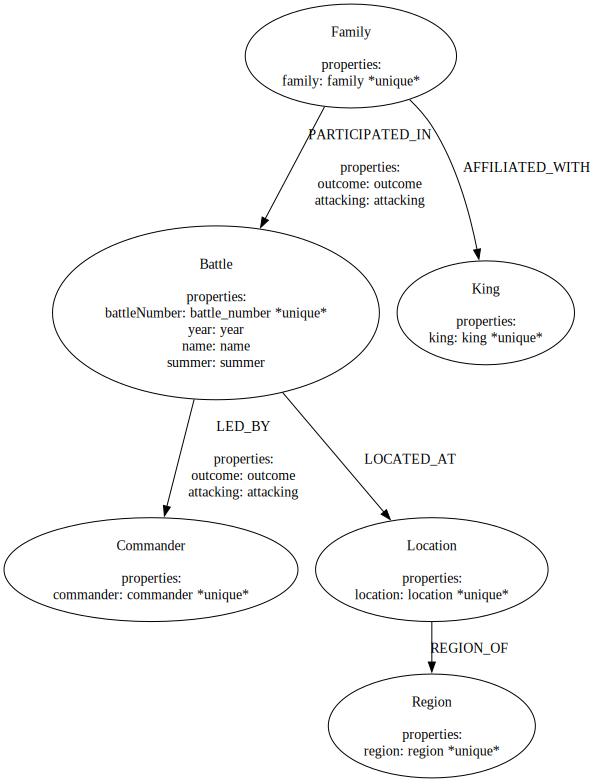

In [13]:
gdm.current_model.visualize()

## Code Generation

In [14]:
gen = PyIngestConfigGenerator(data_model=gdm.current_model, database="gameofthronesmulti", username="neo4j", uri=os.environ.get("NEO4J_URI"), password=os.environ.get("NEO4J_PASSWORD"), file_directory=data_directory)

Generating a file isn't necessary, but it's nice to have in case we want to reload data in the future.

In [15]:
gen.generate_config_yaml(file_name="./outputs/config.yaml")

## Ingest

In [16]:
PyIngest(config=gen.generate_config_string())